# Trainig a Model Using the MNIST datase for recgonise hand-writen digits
   
On this notebook we show how to create a model and train using  MNIST dataset for recognise handwritten digits.
We start showing how to read the bits from the dataset, then we do a quick introduction to neural network what 
is useful for understand the model thath we will train.
We start with a simple linear model, for then add convolutional and maxpooling layers.
At the end we use data augmentation and train for several epoch our model to try to get a high hit on the test data set.



# The Data

  We will start by understanding how the data is formatted and see hot we can parse it in a  suitable way for train our model.
  
  Mnist provide 4 files:
  
  -   training set images 
  -   training set labels
  -   test set images
  -   test set labels 
 
   [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/) 



## Little and Big Endian Architecture 

  There are 2 types of processors architecture(little and big endian). In little endian bits are store from left to right This is basically how the bytes are stored, in little they are stored from left to right and in big the other way around.(Look this is you want to know more about https://chortle.ccsu.edu/AssemblyTutorial/Chapter-15/ass15_3.html ).
  This is relevant for us because we need to know read the bytes right for get the proper data.
  
  In python we can easily check using sys, since I am using a Intel processor I expected to be little.


In [1]:
import numpy as np
from sys import byteorder

Now we can check  our architecture:

In [2]:
print(byteorder)

little


## Reading Mnist

  Now we can start reading the train images file. 
  From Mnist website we know what to expected from each bit read.


In [3]:
import gzip

with gzip.open('mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    fc_train_img = f.read()

  The first 4 bytes is the magic number which is a 32 bit integer, for the image set this number is 2051. Note that we are setting the byte order as big.

In [4]:
int.from_bytes(fc_train_img[0:4], byteorder='big')

2051

Next is the number of images as a 32 bit integer:

In [5]:
train_img_total = int.from_bytes(fc_train_img[4:8], byteorder='big')
train_img_total

60000

Then number of rows as 32 bit integer.

In [6]:
row = int.from_bytes(fc_train_img[8:12], byteorder='big')
row

28

And  columns  32 bit integer as well.

In [7]:
col = int.from_bytes(fc_train_img[12:16], byteorder='big')
col

28

Then all next are  unsigned bytes(8 bits) , each byte represent a pixel. They are organized row-wise.

The total of bits is: 
```python
train_img_total*row*col
```





In [8]:
last_byte = (train_img_total*row*col) + 16
last_byte

47040016

Now whe can read all bits:

In [9]:
x_train = list(fc_train_img[16:last_byte])

And reshape them ass 28*27 (784) array. That is the vector representation of the images.

In Mnist pixel values are 0 to 255.0 , 0 representing the background. We want to invert this, because having a non zero value as background is better for the training.

In [10]:
x_train = ~np.array(x_train).reshape(train_img_total,row*col).astype(np.uint8)
x_train.shape

(60000, 784)

We can see one image using pyplot:

In [11]:
import matplotlib.pyplot as plt
plt.imshow(x_train[11].reshape(row,col), cmap='gray')

Thats look like the image 11 is a 5. We can now read labels and check.

In [12]:
with gzip.open('mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    fc_train_lbl = f.read()

First 32 bits are the magic number : 2049

In [13]:
int.from_bytes(fc_train_lbl[0:4], byteorder='big')


2049

Then a 32 bits integer, the total of labels. Must be 6000 as we got 6000 images.

In [14]:
train_lvl_total = int.from_bytes(fc_train_lbl[4:8], byteorder='big')
train_lvl_total

60000

Now each unsigned byte is a label, so we can check that 11 is 5:

In [15]:
y_train = np.array(list(fc_train_lbl[8:train_lvl_total+8]))
print(y_train[11])

5


We now real the test images and labels:

In [16]:
with gzip.open('mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    fc_test_img = f.read()
with gzip.open('mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    fc_test_lbl = f.read()
    
test_img_total = int.from_bytes(fc_test_img[4:8], byteorder='big')
test_lbl_total = int.from_bytes(fc_test_lbl[4:8], byteorder='big')

last_byte = (test_img_total*row*col) + 16
x_test = list(fc_test_img[16:last_byte])
x_test = ~np.array(x_test).reshape(test_img_total,row*col).astype(np.uint8)

y_test = np.array(list(fc_test_lbl[8:test_lbl_total+8]))

In [17]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [18]:
x_train =  x_train/255.0
x_test = x_test/255.0

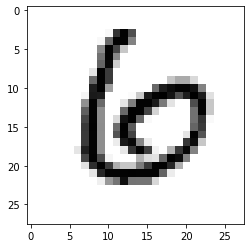

In [19]:
plt.imshow(x_test[11].reshape(row,col), cmap='gray')

In [20]:
print(y_test[11])

6


# Neuron Network

Most people can recognize handwrite digits with no problem(because we have a very complex brain). This is not a easy task for a computer. We will use the neural network approach, we will take a large number of labelled handwrite digits -the training examples- (x_train), and create a model that can learn from those examples.


## Neurons

The idea is simple, they take several inputs(  $ x_1, x_2 ... x_n $) and produce a single output.




![Single neuron](img/SingleNeuron.png)

Each input have  <i>weights</i>  $ w_1, w_2 ... w_n $ , a weight sum is calculated:${\sum_n x_n w_n}$ then the results goes through a activation function.

[http://neuralnetworksanddeeplearning.com/chap1.html](http://neuralnetworksanddeeplearning.com/chap1.html/) 

[https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb](https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb) 



## Layers

We create layers composed of neurons. at least one input layer and a output layer is required, there can be hidden layers between the input and output layer. 

Our images are 28x28, we can create a 784 vector that represent the image. So we will feed out network with 784 inputs, this is our input layer that is also know as hidden layer.
Since we need to discriminate 10 numbers out output layer will have 10 neurons, each will represent a digit from 0 to 9. Then we can use SoftMax activation function for the output of each of our network to represent a probability of being a digit.


## Activation : softmax
   We want our result to represent a probability of being one of the 10 digits(0,1,3...).
  The SoftMax activation function will do this for us, it will output our output for each neuron between 0 and 1.Then each 
  of our neuron can represent a digit so the one will bigger probability will be our prediction.

  
  $$\sigma (z)_j = \frac{e^{(z)_j}}{\sum_{k=0}^{K}e^{(z)_k}} \text{  where   j = 1,...,K}$$  
  
  In our case K = 10.
  
  https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/

## First model

 We will start create a 2 layers model, input and output : the input layer will be the 784 vector created with the image data and the output a 10 neuros with activation SoftMax. 
 

![Single neuron](img/Model1.png)

We will use keras and TensorFlow

In [21]:
import keras as kr

Using TensorFlow backend.


In [22]:
# create sequeantial model
model = kr.models.Sequential()

# The input layer is added by keras when we set input = 784 
# We add 10 neuroas with softmax for output
model.add(kr.layers.Dense(units=10, input_dim=784, activation='softmax'))

# Compile the model.
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

We can se a summary of our model:

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


The 7850 parameters are:
 10 weights from each input node to each output made 7840 plus 10 weights on the outputs nodes.


We are missing few thinks to explain: loss, optimizer and metrics.

## Loss : categorical_crossentropy


 This is how we measure how well our algorithm model the dataset. 
   
 Categorical cross entropy is used when only one value can belong to each class (our 10 outputs), so just what we need for measure our model because we are looking for predicted one number. Our output should be the number prediction.

   
   [https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy)
   
   
  [https://algorithmia.com/blog/introduction-to-loss-functions](https://algorithmia.com/blog/introduction-to-loss-functions)
    

## Optimazer : adam

When we are training our model the weights are change acordally for make our prediction better. How much and how are they change is the job of the optimizer, is the optimizer who shape our model for a correct prediction.

Adaptative moment estimation(ADAM) use gradient decent. This is how it work([literally taked from Algorithmia](https://algorithmia.com/blog/introduction-to-optimizers)  )


1) Calculate what a small change in each individual weight would do to the loss function (i.e. which direction should the hiker walk in)

2) Adjust each individual weight based on its gradient (i.e. take a small step in the determined direction)

3) Keep doing steps #1 and #2 until the loss function gets as low as possible



Adam use pas gradients to calculate current gradients and also utilizes the concept of [momentun](https://ruder.io/optimizing-gradient-descent/index.html#momentum).


[https://keras.io/optimizers/](https://keras.io/optimizers/)


[https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html](https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html)


[https://https://algorithmia.com/blog/introduction-to-optimizers.com/blog/introduction-to-optimizers](https://https://algorithmia.com/blog/introduction-to-optimizers.com/blog/introduction-to-optimizers)

## Preparing the labes
    
We are almost done for train our model for first time, the only problems is that our labels are a single digit. We need make them vectors with a 1 on the number position.

In [24]:
y_train = kr.utils.to_categorical(y_train, 10)
y_test  = kr.utils.to_categorical(y_test, 10)

In [25]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Now we are ready, we will start training this simple model with 10 epochs, batch of 100 (means we train the model with 100 images at a time).

In [26]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.8062 - accuracy: 0.7910 - val_loss: 0.4506 - val_accuracy: 0.8833
Epoch 2/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4284 - accuracy: 0.8801 - val_loss: 0.3739 - val_accuracy: 0.8932
Epoch 3/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.3769 - accuracy: 0.8913 - val_loss: 0.3539 - val_accuracy: 0.8952
Epoch 4/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3538 - accuracy: 0.8974 - val_loss: 0.3234 - val_accuracy: 0.9075
Epoch 5/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3396 - accuracy: 0.9011 - val_loss: 0.3126 - val_accuracy: 0.9114
Epoch 6/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3289 - accuracy: 0.9051 - val_loss: 0.3046 - val_accuracy: 0.9145
Epoch 7/10
60000/60000 [==============================] - 1s 22us/st

## First results

We have achieved a 99.67 accuracy with this very simple model, this is going to be our baseline and we change our model for improve the results.

We can get data history, since we will be doing this several times I also define a function for use later.

In [27]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

Blue is test accuracy on training set and red is the accuracy on the test set. We want to improve red.

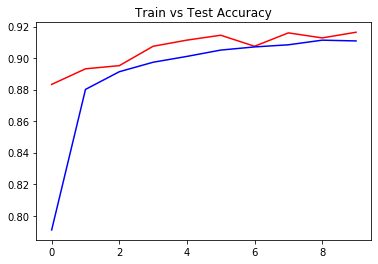

In [28]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

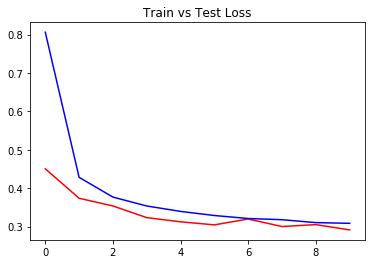

In [30]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

We got to 89% accuracy with just 10 simple neurons, this is our output layer and we can of course improve our model.

# Adding more Layers and Relu activation function

# Relu

Rectified linear unit(Relu), is one of the most common activation functions in neural networks. Relu is very simple, linear for all positive values and 0 for all negative values:
$$ f(x)       \begin{cases}
       \text{0,} &\quad\text{if } x \le0\\
       f(x) &\quad\text{if } x  >0 \\
       \end{cases}$$


![Relu](img/relu.png)

# Some advantages of Relu:
- Cheap to compute.
- Good sparsity.
- Converge faster.

[https://keras.io/activations/](https://keras.io/activations/)

[https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7) 

[https://datascience.stackexchange.com/questions/14349/difference-of-activation-functions-in-neural-networks-in-general](https://datascience.stackexchange.com/questions/14349/difference-of-activation-functions-in-neural-networks-in-general)

## Extra layers

We can now add more layers using Relu activation function:
- Same input layer.
- Hidden layers  512 and 98 neurons, with Relu.
- Same output layer, 10 neurons with SoftMax.

In [31]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 98)                50274     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                990       
Total params: 453,184
Trainable params: 453,184
Non-trainable params: 0
_________________________________________________________________


In [33]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.5613 - accuracy: 0.8298 - val_loss: 0.3411 - val_accuracy: 0.9002
Epoch 2/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.2981 - accuracy: 0.9098 - val_loss: 0.2652 - val_accuracy: 0.9159
Epoch 3/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.2402 - accuracy: 0.9270 - val_loss: 0.1969 - val_accuracy: 0.9397
Epoch 4/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1895 - accuracy: 0.9423 - val_loss: 0.1636 - val_accuracy: 0.9475
Epoch 5/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1657 - accuracy: 0.9501 - val_loss: 0.1644 - val_accuracy: 0.9513
Epoch 6/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1500 - accuracy: 0.9542 - val_loss: 0.1439 - val_accuracy: 0.9565
Epoch 7/10
60000/60000 [==============================] - 2s 28us/st

In [35]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

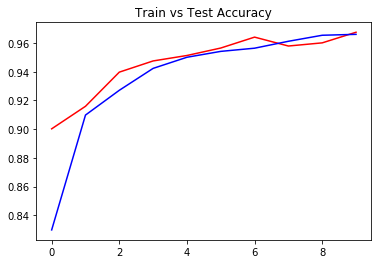

In [36]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

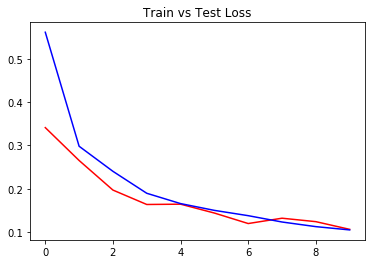

In [37]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

Relu and the extra layers have give a great improvement to our model, from 89% to 96%.

# Dropout

Drop out is regularization technic, basically we drop some random neurons during training, 
they are temporary shutted down. 

Is believe that this make other neurons be more active so improve the learning rate.

The effect is a network that is less sensitive to specific weights of neurons. The network is capable of a better generalization and avoid overfit.

Drop out is very easily implemented with Keras, we just need to pick a percent of dropped out neurons for each epoch.


[https://keras.io/layers/core/](https://keras.io/layers/core/)

[https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

In [38]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dropout(0.01))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 98)                50274     
_________________________________________________________________
dropout_2 (Dropout)          (None, 98)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                990       
Total params: 453,184
Trainable params: 453,184
Non-trainable params: 0
_________________________________________________________________


In [40]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.6175 - accuracy: 0.8092 - val_loss: 0.3019 - val_accuracy: 0.9085
Epoch 2/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.3136 - accuracy: 0.9030 - val_loss: 0.2314 - val_accuracy: 0.9305
Epoch 3/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.2428 - accuracy: 0.9263 - val_loss: 0.1639 - val_accuracy: 0.9491
Epoch 4/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.2002 - accuracy: 0.9385 - val_loss: 0.1434 - val_accuracy: 0.9547
Epoch 5/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.1748 - accuracy: 0.9463 - val_loss: 0.1680 - val_accuracy: 0.9444
Epoch 6/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.1608 - accuracy: 0.9498 - val_loss: 0.1430 - val_accuracy: 0.9531
Epoch 7/10
60000/60000 [==============================] - 2s 31us/st

In [44]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

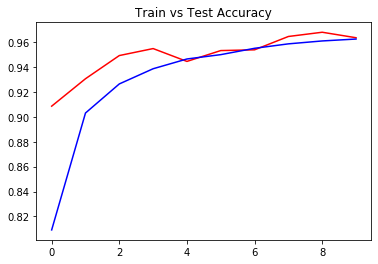

In [45]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

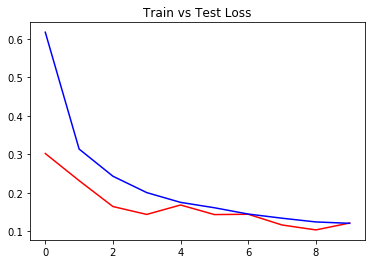

In [46]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

Dropout improve our model from 96% to 96.5%, litle improvement but relevant.

# 2D Convolutional Neural Network

We have achieve 97% accuracy on our model, but we are missing a very important point : shapes are 2D images and there is a relation between pixels. Transforming our image in a 1D vector we completely ignore the shape of the image.
Using convolutional neurons we can feed neurons with 2D arrays of pixels and someone preserve the data on the shape of the image.

In the image bellow we can see how a 3x3 convolutional networks works. Note that the image is just for illustrate how convolutional networks works, is not related with the one we will use.


![Conv2d](img/conv2d.gif)

### image from:  [https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)

[https://keras.io/layers/convolutional/](https://keras.io/layers/convolutional/)

[https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

## Reforating input data for convolutional network

We now need to reshape our data for be a 28 by 28 array so it can be fit onto the convolutional network.

In [47]:
x_train = x_train.reshape(train_img_total,col,row,1)
x_test = x_test.reshape(test_img_total,col,row,1)

In [48]:
x_train.shape

(60000, 28, 28, 1)

In [49]:
model = kr.models.Sequential()

model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [50]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 235us/step - loss: 0.3592 - accuracy: 0.9028 - val_loss: 0.0852 - val_accuracy: 0.9738
Epoch 2/10
60000/60000 [==============================] - 12s 196us/step - loss: 0.1007 - accuracy: 0.9700 - val_loss: 0.0670 - val_accuracy: 0.9793
Epoch 3/10
60000/60000 [==============================] - 12s 197us/step - loss: 0.0706 - accuracy: 0.9786 - val_loss: 0.0613 - val_accuracy: 0.9798
Epoch 4/10
60000/60000 [==============================] - 12s 206us/step - loss: 0.0524 - accuracy: 0.9837 - val_loss: 0.0649 - val_accuracy: 0.9805
Epoch 5/10
60000/60000 [==============================] - 12s 206us/step - loss: 0.0411 - accuracy: 0.9867 - val_loss: 0.0572 - val_accuracy: 0.9806
Epoch 6/10
60000/60000 [==============================] - 12s 199us/step - loss: 0.0329 - accuracy: 0.9895 - val_loss: 0.0563 - val_accuracy: 0.9834
Epoch 7/10
60000/60000 [==============================] 

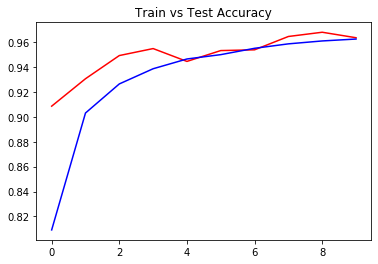

In [51]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

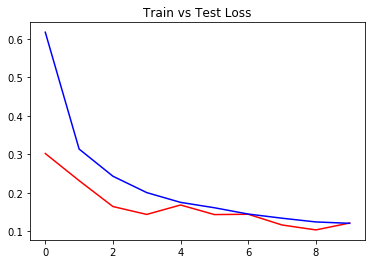

In [52]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

With just 1 convolutional layer we have improve our accuracy to 98%. Great improvement but there is still place for more...

## More layers and max polling

A polling layer is a layer that we add after a convolutional layer.  The polling layer will operate over each pixel for create a new set of pulled data. We will use max polling of size 2x2 pixels. This means that the maximum of each 2x2 patch will be calculated.

### Benefits:

- Model invariance to local translation.
- Faster computations.



![MAxPolling2d](img/maxpolling2d.png)

image from: [https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)

[https://keras.io/layers/pooling/](https://keras.io/layers/pooling/)

[https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

In [53]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [54]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.2164 - accuracy: 0.9304 - val_loss: 0.0632 - val_accuracy: 0.9809
Epoch 2/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0615 - accuracy: 0.9825 - val_loss: 0.0319 - val_accuracy: 0.9907
Epoch 3/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0451 - accuracy: 0.9866 - val_loss: 0.0312 - val_accuracy: 0.9904
Epoch 4/10
60000/60000 [==============================] - 6s 92us/step - loss: 0.0348 - accuracy: 0.9900 - val_loss: 0.0373 - val_accuracy: 0.9893
Epoch 5/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.0301 - accuracy: 0.9913 - val_loss: 0.0342 - val_accuracy: 0.9902
Epoch 6/10
60000/60000 [==============================] - 6s 92us/step - loss: 0.0275 - accuracy: 0.9925 - val_loss: 0.0363 - val_accuracy: 0.9897
Epoch 7/10
60000/60000 [==============================] - 5s 91us/st

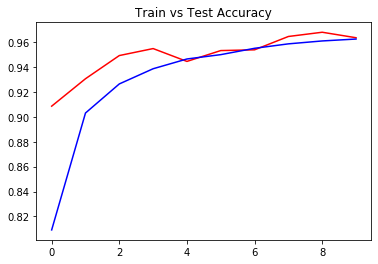

In [59]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

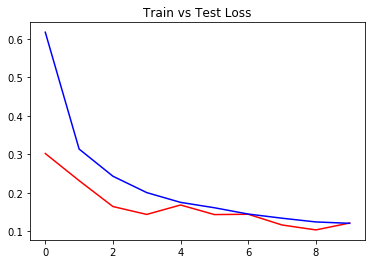

In [60]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

Great improvement , we are at 99.5% now. 



## Batch normalization

## Batch Normalization


We can normalize beetwen layers for speed up training. Normalization function will keep values at same range, mean that we will not have very high values.

Some advatages:

- Layers can learn  a bit more independently.
- Allow higher rate of leanrning.
- Reduce overfit.

https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

https://arxiv.org/pdf/1502.03167v2.pdf

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
    

In [61]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu'))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [62]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.2262 - accuracy: 0.9270 - val_loss: 0.0650 - val_accuracy: 0.9804
Epoch 2/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0634 - accuracy: 0.9815 - val_loss: 0.0449 - val_accuracy: 0.9873
Epoch 3/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0480 - accuracy: 0.9860 - val_loss: 0.0387 - val_accuracy: 0.9884
Epoch 4/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.0366 - accuracy: 0.9891 - val_loss: 0.0298 - val_accuracy: 0.9923
Epoch 5/10
60000/60000 [==============================] - 6s 92us/step - loss: 0.0315 - accuracy: 0.9907 - val_loss: 0.0274 - val_accuracy: 0.9916
Epoch 6/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.0263 - accuracy: 0.9920 - val_loss: 0.0397 - val_accuracy: 0.9891
Epoch 7/10
60000/60000 [==============================] - 5s 90us/st

In [63]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

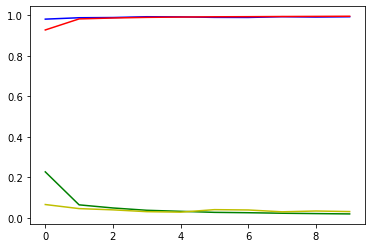

In [64]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

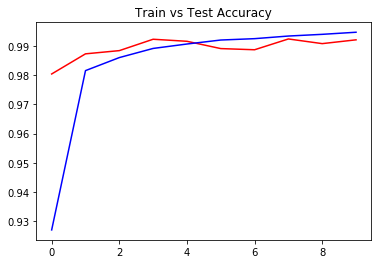

In [65]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

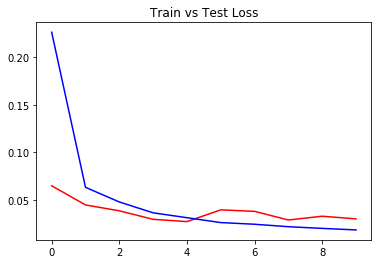

In [66]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

# Final Model

![Final Model](img/finalmodel.png)

* image created using : [NN-SVG](http://alexlenail.me/NN-SVG/LeNet.html)


In [91]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.normalization.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu'))
kr.layers.normalization.BatchNormalization(axis=-1)
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Flatten())
kr.layers.normalization.BatchNormalization()
model.add(kr.layers.Dense(units=128, activation='relu'))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss=kr.losses.categorical_crossentropy,optimizer='adadelta',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 22, 22, 64)        3200      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 64)        200768    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 2, 256)         295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 1, 256)        

# Data Augmentation Image Generator

We we able to reach  maximun of 99.5% on our test data. Could be great if we can have more data for train the model, the great news are that we can generate more data and keras has librarys that do it for us...


https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced


In [92]:
from keras.preprocessing.image import ImageDataGenerator

We just need to set parameters of our image generator generate images with litle variations.

In [93]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

In [94]:
train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_test, y_test, batch_size=64)

Code below will generate a batch of 64 images in x1 and 64 labels in y1

In [95]:
x1,y1 = train_generator.next()

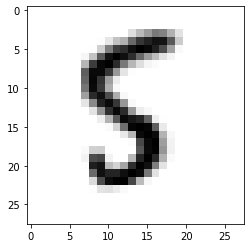

In [96]:
plt.imshow(x1[3].reshape(28,28), cmap='gray')

In [97]:
y1[3]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

They look very similar but this will give a great improvement to our model performance...

In [98]:
epoch =10
history_callback= model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=epoch, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/10
937/937 [==============================] - 9s 10ms/step - loss: 0.3561 - accuracy: 0.8844 - val_loss: 0.0272 - val_accuracy: 0.9862
Epoch 2/10
937/937 [==============================] - 9s 10ms/step - loss: 0.0807 - accuracy: 0.9771 - val_loss: 0.1172 - val_accuracy: 0.9906
Epoch 3/10
937/937 [==============================] - 9s 10ms/step - loss: 0.0597 - accuracy: 0.9827 - val_loss: 0.0011 - val_accuracy: 0.9936
Epoch 4/10
937/937 [==============================] - 10s 11ms/step - loss: 0.0474 - accuracy: 0.9868 - val_loss: 1.7362e-04 - val_accuracy: 0.9926
Epoch 5/10
937/937 [==============================] - 9s 10ms/step - loss: 0.0432 - accuracy: 0.9879 - val_loss: 4.6153e-04 - val_accuracy: 0.9932
Epoch 6/10
937/937 [==============================] - 9s 10ms/step - loss: 0.0391 - accuracy: 0.9886 - val_loss: 5.0968e-04 - val_accuracy: 0.9931
Epoch 7/10
937/937 [==============================] - 10s 11ms/step - loss: 0.0352 - accuracy: 0.9902 - val_loss: 1.7088e-04 - va

In [99]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])


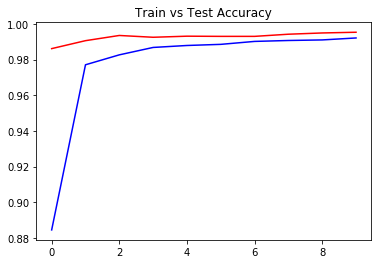

In [100]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

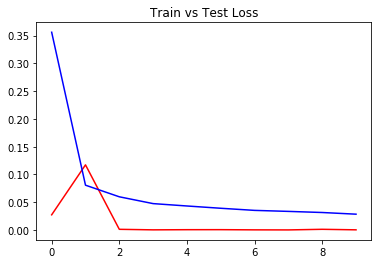

In [101]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

# Looking for high hit

As we want a static model with high acuracy on the original Mnist train set. We can notice that the accuracy vary from epoch going up and down, also there is a litle variation on the accuracy on the original train set and the generated train set. So we will add a callback fucntion that check accurracy against original test set after each epoch,  then if the accuaracy is higher than the minimun or the last high model we save the model. 

In this way we are looking for a "lucky" hit.

## Custom Checkpoint


In [102]:
class CustomModelCheckpoint(kr.callbacks.Callback):
    minimun = 0.995
    def on_epoch_end(self, epoch, logs=None):
        # calculate accuracy again original test set
        score = self.model.evaluate(x_test, y_test, verbose=0)
        print(score[1])
        if score[1] > self.minimun: # your custom conditio
            #save the model if is higher
            self.model.save('static/model.h5', overwrite=True)
            self.minimun = score[1]
            # print the real acurracy
            print("*******************************************************************************************************")
            print(self.minimun)
            print("*******************************************************************************************************")

In [103]:
cbk = CustomModelCheckpoint()

In [104]:
epoch =150
history_callback= model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=epoch, 
                    validation_data=test_generator, validation_steps=10000//64, callbacks=[cbk])

Epoch 1/150
937/937 [==============================] - 10s 10ms/step - loss: 0.0288 - accuracy: 0.9921 - val_loss: 0.1085 - val_accuracy: 0.9950
0.9950000047683716
*******************************************************************************************************
0.9950000047683716
*******************************************************************************************************
Epoch 2/150
937/937 [==============================] - 10s 11ms/step - loss: 0.0261 - accuracy: 0.9926 - val_loss: 0.0092 - val_accuracy: 0.9945
0.9944999814033508
Epoch 3/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0243 - accuracy: 0.9930 - val_loss: 3.5448e-05 - val_accuracy: 0.9950
0.9948999881744385
Epoch 4/150
937/937 [==============================] - 10s 10ms/step - loss: 0.0250 - accuracy: 0.9934 - val_loss: 0.0556 - val_accuracy: 0.9944
0.9944999814033508
Epoch 5/150
937/937 [==============================] - 10s 11ms/step - loss: 0.0240 - accuracy: 0.9933 - val_loss:

0.9955000281333923
Epoch 45/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 3.5502e-04 - val_accuracy: 0.9959
0.9951000213623047
Epoch 46/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0130 - accuracy: 0.9967 - val_loss: 0.0810 - val_accuracy: 0.9950
0.9951000213623047
Epoch 47/150
937/937 [==============================] - 10s 11ms/step - loss: 0.0113 - accuracy: 0.9972 - val_loss: 0.0000e+00 - val_accuracy: 0.9949
0.9951000213623047
Epoch 48/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0132 - accuracy: 0.9970 - val_loss: 1.4901e-08 - val_accuracy: 0.9955
0.9947999715805054
Epoch 49/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0122 - accuracy: 0.9969 - val_loss: 0.0017 - val_accuracy: 0.9954
0.9955000281333923
Epoch 50/150
937/937 [==============================] - 10s 11ms/step - loss: 0.0118 - accuracy: 0.9971 - val_loss: 5.8486e-07 - val_accuracy: 0.995

937/937 [==============================] - 9s 10ms/step - loss: 0.0122 - accuracy: 0.9978 - val_loss: 1.5403e-06 - val_accuracy: 0.9957
0.9962999820709229
Epoch 95/150
937/937 [==============================] - 10s 11ms/step - loss: 0.0132 - accuracy: 0.9973 - val_loss: 0.3830 - val_accuracy: 0.9952
0.9948999881744385
Epoch 96/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 0.1167 - val_accuracy: 0.9953
0.9957000017166138
Epoch 97/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0138 - accuracy: 0.9975 - val_loss: 1.9382e-04 - val_accuracy: 0.9957
0.9954000115394592
Epoch 98/150
937/937 [==============================] - 10s 11ms/step - loss: 0.0122 - accuracy: 0.9973 - val_loss: 3.7253e-08 - val_accuracy: 0.9957
0.9955000281333923
Epoch 99/150
937/937 [==============================] - 10s 10ms/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 1.1660e-06 - val_accuracy: 0.9957
0.9958000183105469
Epoch 100/

0.9955999851226807
Epoch 143/150
937/937 [==============================] - 10s 11ms/step - loss: 0.0122 - accuracy: 0.9975 - val_loss: 3.4430e-04 - val_accuracy: 0.9954
0.9957000017166138
Epoch 144/150
937/937 [==============================] - 10s 10ms/step - loss: 0.0141 - accuracy: 0.9974 - val_loss: 0.0000e+00 - val_accuracy: 0.9960
0.9955999851226807
Epoch 145/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0096 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 0.9950
0.9952999949455261
Epoch 146/150
937/937 [==============================] - 53s 57ms/step - loss: 0.0119 - accuracy: 0.9975 - val_loss: 1.6987e-06 - val_accuracy: 0.9955
0.9951000213623047
Epoch 147/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0111 - accuracy: 0.9978 - val_loss: 0.0011 - val_accuracy: 0.9959
0.9955999851226807
Epoch 148/150
937/937 [==============================] - 9s 10ms/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 0.0015 - val_accuracy

In [84]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])


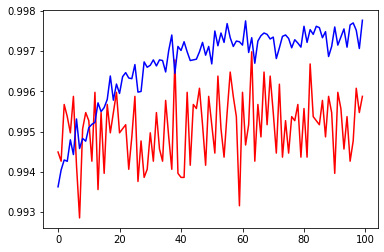

In [85]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'r',x,accuracy,'b')#,x,loss,'g',x,val_loss,'y')

In [86]:
loss[92]

0.013674805246103823

In [90]:
score = kr.models.load_model('./static/model.h5').evaluate(x_test, y_test, verbose=0)
score

[0.02925015318478716, 0.9965999722480774]

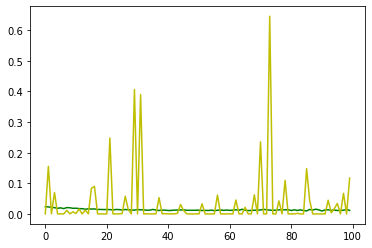

In [88]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,loss,'g',x,val_loss,'y')